In [1]:
import os
import boto3

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
s3 = boto3.client("s3")

filename = "banknotes.csv"
s3.download_file("sagemaker-ml-bucket-harini-2022","training-data/banknotes.csv",filename)
df = pd.read_csv(filename)

In [10]:
df.head()

,variace,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [11]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [12]:
import seaborn as sns

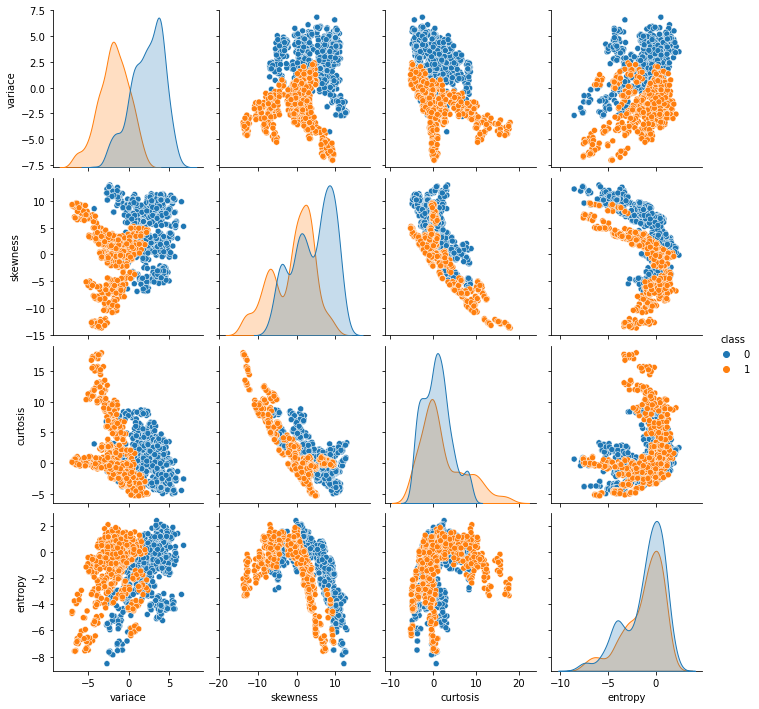

In [13]:
sns.pairplot(df,hue="class")

# Baseline Model

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

In [21]:
X = scale(df.drop('class', axis=1).values)

In [22]:
X

array([[ 1.12180565,  1.14945512, -0.97597007,  0.35456135],
       [ 1.44706568,  1.06445293, -0.89503626, -0.12876744],
       [ 1.20780971, -0.77735215,  0.12221838,  0.61807317],
       ...,
       [-1.47235682, -2.62164576,  3.75901744, -0.75488418],
       [-1.40669251, -1.75647104,  2.552043  , -0.04315848],
       [-1.04712236, -0.43982168,  0.29861555,  1.1364645 ]])

In [23]:
y = df['class'].values

In [24]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [25]:
model = RandomForestClassifier()
cross_val_score(model, X, y)

array([0.99272727, 0.99636364, 0.98540146, 0.99635036, 0.99635036])

# Logistic Regression Model

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [39]:
K.clear_session()

model = Sequential()
model.add(Dense(1, input_shape=(4,),activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,epochs=10)
result = model.evaluate(X_test, y_test)

Epoch 1/10
960/960 [==============================] - 0s 467us/step - loss: 0.7892 - accuracy: 0.4500
Epoch 2/10
960/960 [==============================] - 0s 67us/step - loss: 0.7498 - accuracy: 0.5177
Epoch 3/10
960/960 [==============================] - 0s 81us/step - loss: 0.7159 - accuracy: 0.5510
Epoch 4/10
960/960 [==============================] - 0s 200us/step - loss: 0.6863 - accuracy: 0.5781
Epoch 5/10
960/960 [==============================] - 0s 152us/step - loss: 0.6602 - accuracy: 0.6073
Epoch 6/10
960/960 [==============================] - 0s 142us/step - loss: 0.6369 - accuracy: 0.6375
Epoch 7/10
960/960 [==============================] - 0s 87us/step - loss: 0.6158 - accuracy: 0.6521
Epoch 8/10
960/960 [==============================] - 0s 89us/step - loss: 0.5966 - accuracy: 0.6740
Epoch 9/10
960/960 [==============================] - 0s 72us/step - loss: 0.5790 - accuracy: 0.6906
Epoch 10/10
412/412 [==============================] - 0s 240us/step


In [40]:
historydf = pd.DataFrame(history.history, index=history.epoch)

Text(0.5, 1.0, 'Test accuracy: 57.9 %')

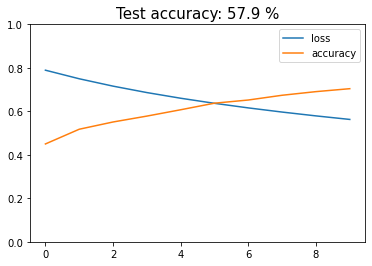

In [41]:
historydf.plot(ylim=(0,1))
plt.title("Test accuracy: {:3.1f} %".format(result[0]*100),fontsize=15)

# Learning Rates

In [42]:
dflist = []

learning_rates = [0.01, 0.05, 0.1, 0.5]

for lr in learning_rates:
    K.clear_session()

    model = Sequential()
    model.add(Dense(1, input_shape=(4,),activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=lr),
              metrics=['accuracy'])

    h = model.fit(X_train, y_train,epochs=10,batch_size=16,verbose=0)
    dflist.append(pd.DataFrame(h.history,index=h.epoch))

In [45]:
historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([learning_rates, metrics_reported],
                                names=['learning_rate','metric'])
historydf.columns = idx

In [46]:
historydf

learning_rate      0.01                0.05                0.10            \
metric             loss  accuracy      loss  accuracy      loss  accuracy   
0              0.701551  0.555208  0.657073  0.620833  0.473840  0.832292   
1              0.588979  0.656250  0.441255  0.818750  0.284549  0.922917   
2              0.515901  0.777083  0.355993  0.868750  0.225481  0.937500   
3              0.465651  0.840625  0.303889  0.905208  0.190136  0.952083   
4              0.428914  0.865625  0.266896  0.919792  0.166011  0.956250   
5              0.400438  0.880208  0.238902  0.936458  0.148506  0.964583   
6              0.377469  0.889583  0.216791  0.946875  0.135147  0.965625   
7              0.358254  0.900000  0.198989  0.948958  0.124807  0.968750   
8              0.341813  0.908333  0.184396  0.957292  0.116347  0.969792   
9              0.327440  0.912500  0.172133  0.959375  0.109488  0.969792   

learning_rate      0.50            
metric             loss  accuracy  
0              0.262637  0.915625  
1              0.122387  0.967708  
2              0.093728  0.975000  
3              0.079012  0.976042  
4              0.070619  0.979167  
5              0.064698  0.979167  
6              0.060432  0.979167  
7              0.057336  0.981250  
8              0.054341  0.981250  
9              0.052416  0.982292

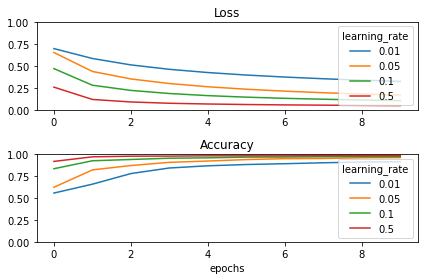

In [47]:
ax = plt.subplot(211)
historydf.xs('loss',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Loss')

ax = plt.subplot(212)
historydf.xs('accuracy',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Accuracy')
plt.xlabel("epochs")

plt.tight_layout()

# Batch sizes

In [48]:
dflist = []

batch_sizes = [16, 32, 64, 128]

for batch_size in batch_sizes:
    K.clear_session()

    model = Sequential()
    model.add(Dense(1, input_shape=(4,),activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    h = model.fit(X_train, y_train,epochs=10,batch_size=batch_size,verbose=0)
    dflist.append(pd.DataFrame(h.history,index=h.epoch))

In [51]:
historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([batch_sizes, metrics_reported],
                                names=['batch_size','metric'])
historydf.columns = idx

In [52]:
historydf

batch_size       16                  32                  64             \
metric          loss  accuracy      loss  accuracy      loss  accuracy   
0           1.223499  0.432292  1.117834  0.360417  0.583916  0.686458   
1           0.918036  0.484375  0.975141  0.398958  0.558265  0.746875   
2           0.705859  0.548958  0.853550  0.457292  0.535107  0.796875   
3           0.575896  0.712500  0.751953  0.523958  0.514167  0.842708   
4           0.498385  0.848958  0.668833  0.633333  0.495171  0.872917   
5           0.449199  0.880208  0.601416  0.752083  0.477989  0.903125   
6           0.415075  0.897917  0.547499  0.851042  0.462378  0.918750   
7           0.389593  0.900000  0.504115  0.910417  0.448129  0.921875   
8           0.369422  0.902083  0.469070  0.933333  0.435140  0.927083   
9           0.352625  0.905208  0.440516  0.954167  0.423209  0.932292   

batch_size       128            
metric          loss  accuracy  
0           0.674229  0.597917  
1           0.655015  0.618750  
2           0.636920  0.633333  
3           0.620553  0.662500  
4           0.605264  0.682292  
5           0.591066  0.703125  
6           0.578008  0.717708  
7           0.565379  0.733333  
8           0.553540  0.759375  
9           0.542591  0.779167

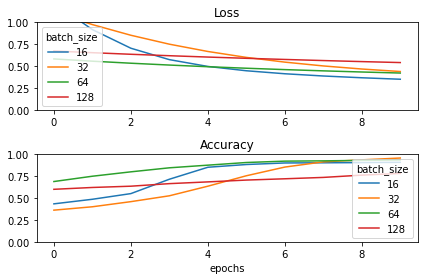

In [53]:
ax = plt.subplot(211)
historydf.xs('loss',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Loss')

ax = plt.subplot(212)
historydf.xs('accuracy',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Accuracy')
plt.xlabel("epochs")

plt.tight_layout()

# Optimizers

In [54]:
from keras.optimizers import SGD, Adam, Adagrad, RMSprop

In [60]:
dflist = []

optimizers = ['SGD(lr=0.01)',
              'SGD(lr=0.01, momentum=0.3)',
              'SGD(lr=0.01, momentum=0.3, nesterov=True)',
              'Adam(lr=0.01)',
              'Adagrad(lr=0.01)',
              'RMSprop(lr=0.01)']

for opt_name in optimizers:
    K.clear_session()

    model = Sequential()
    model.add(Dense(1, input_shape=(4,),activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer=eval(opt_name),
              metrics=['accuracy'])

    h = model.fit(X_train, y_train,batch_size=16,epochs=5,verbose=0)
    dflist.append(pd.DataFrame(h.history,index=h.epoch))

In [61]:
historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([optimizers, metrics_reported],
                                names=['optimizer','metric'])
historydf.columns = idx

In [62]:
historydf

optimizer SGD(lr=0.01)           SGD(lr=0.01, momentum=0.3)            \
metric            loss  accuracy                       loss  accuracy   
0             1.451077  0.228125                   0.457398  0.896875   
1             1.126534  0.244792                   0.412566  0.901042   
2             0.880773  0.338542                   0.379599  0.904167   
3             0.709429  0.529167                   0.353951  0.910417   
4             0.595345  0.764583                   0.333227  0.916667   

optimizer SGD(lr=0.01, momentum=0.3, nesterov=True)           Adam(lr=0.01)  \
metric                                         loss  accuracy          loss   
0                                          1.069073  0.368750      0.760286   
1                                          0.750662  0.501042      0.565259   
2                                          0.580876  0.696875      0.429941   
3                                          0.488631  0.832292      0.336709   
4                                          0.431639  0.870833      0.271023   

optimizer           Adagrad(lr=0.01)           RMSprop(lr=0.01)            
metric     accuracy             loss  accuracy             loss  accuracy  
0          0.573958         0.571602  0.679167         0.518433  0.788542  
1          0.664583         0.511000  0.747917         0.370533  0.866667  
2          0.797917         0.477907  0.801042         0.280436  0.906250  
3          0.893750         0.454347  0.836458         0.219547  0.928125  
4          0.928125         0.435974  0.848958         0.174663  0.942708

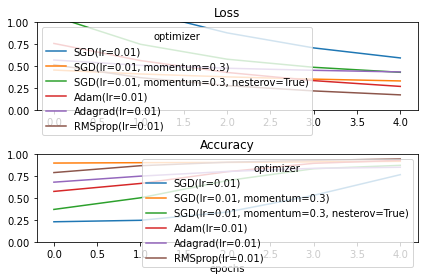

In [63]:
ax = plt.subplot(211)
historydf.xs('loss',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Loss')

ax = plt.subplot(212)
historydf.xs('accuracy',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Accuracy')
plt.xlabel("epochs")

plt.tight_layout()

# Initialization

In [64]:
dflist = []

initializers = ['zeros','uniform','normal',
                'he_normal','lecun_uniform']

for init in initializers:
    K.clear_session()

    model = Sequential()
    model.add(Dense(1, input_shape=(4,),kernel_initializer=init,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

    h = model.fit(X_train, y_train,batch_size=16,epochs=5,verbose=0)
    dflist.append(pd.DataFrame(h.history,index=h.epoch))

In [65]:
historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([initializers, metrics_reported],
                                names=['initializer','metric'])
historydf.columns = idx

In [66]:
historydf

initializer     zeros             uniform              normal            \
metric           loss  accuracy      loss  accuracy      loss  accuracy   
0            0.671099  0.783333  0.689458  0.481250  0.709447  0.223958   
1            0.637864  0.813542  0.654464  0.727083  0.672636  0.621875   
2            0.608708  0.818750  0.624028  0.770833  0.640897  0.721875   
3            0.581840  0.826042  0.596367  0.783333  0.612233  0.765625   
4            0.556852  0.834375  0.571461  0.802083  0.585693  0.782292   

initializer he_normal           lecun_uniform            
metric           loss  accuracy          loss  accuracy  
0            0.855871  0.332292      0.806829  0.401042  
1            0.803785  0.358333      0.757526  0.466667  
2            0.753944  0.406250      0.713403  0.535417  
3            0.710071  0.526042      0.672088  0.632292  
4            0.669325  0.734375      0.635856  0.691667

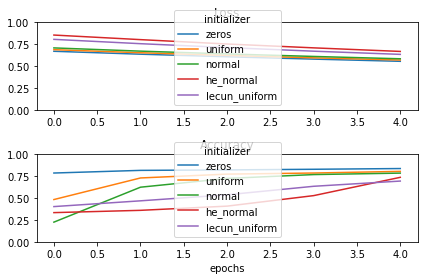

In [67]:
ax = plt.subplot(211)
historydf.xs('loss',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Loss')

ax = plt.subplot(212)
historydf.xs('accuracy',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
plt.title('Accuracy')
plt.xlabel("epochs")

plt.tight_layout()

# Inner layer representation

In [83]:
K.clear_session()

model = Sequential()
model.add(Dense(2, input_shape=(4,),activation='relu'))
model.add(Dense(1,activation='sigmoid'))    

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

h = model.fit(X_train, y_train,batch_size=16,epochs=20,validation_split=0.3)
result = model.evaluate(X_test,y_test)

Train on 672 samples, validate on 288 samples
Epoch 1/20
672/672 [==============================] - 1s 985us/step - loss: 0.7515 - accuracy: 0.4792 - val_loss: 0.6059 - val_accuracy: 0.5104
Epoch 2/20
672/672 [==============================] - 0s 195us/step - loss: 0.5218 - accuracy: 0.6652 - val_loss: 0.4999 - val_accuracy: 0.8160
Epoch 3/20
672/672 [==============================] - 0s 234us/step - loss: 0.4146 - accuracy: 0.8676 - val_loss: 0.3821 - val_accuracy: 0.8819
Epoch 4/20
672/672 [==============================] - 0s 229us/step - loss: 0.2686 - accuracy: 0.9003 - val_loss: 0.2052 - val_accuracy: 0.9097
Epoch 5/20
672/672 [==============================] - 0s 181us/step - loss: 0.1554 - accuracy: 0.9345 - val_loss: 0.1174 - val_accuracy: 0.9618
Epoch 6/20
672/672 [==============================] - 0s 189us/step - loss: 0.0987 - accuracy: 0.9598 - val_loss: 0.0696 - val_accuracy: 0.9792
Epoch 7/20
672/672 [==============================] - 0s 182us/step - loss: 0.0664 - accur

In [84]:
result

[0.030230327319462322, 0.987864077091217]

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.layers

In [87]:
inp = model.layers[0].input
out = model.layers[0].output

In [88]:
inp

<tf.Tensor 'dense_1_input:0' shape=(None, 4) dtype=float32>

In [89]:
out

<tf.Tensor 'dense_1/Relu:0' shape=(None, 2) dtype=float32>

In [90]:
features_function = K.function([inp],[out])

In [78]:
features_function

In [91]:
features_function([X_test])[0].shape

(412, 2)

In [92]:
features = features_function([X_test])[0]

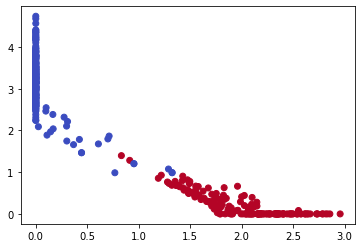

In [93]:
plt.scatter(features[:,0],features[:,1],c=y_test,cmap='coolwarm')

In [94]:
K.clear_session()

model = Sequential()
model.add(Dense(2, input_shape=(4,),activation='relu'))
model.add(Dense(2,activation='sigmoid')) 
model.add(Dense(1,activation='sigmoid'))    

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])


In [95]:
inp = model.layers[0].input
out = model.layers[0].output
features_function = K.function([inp],[out])

412/412 [==============================] - 0s 42us/step


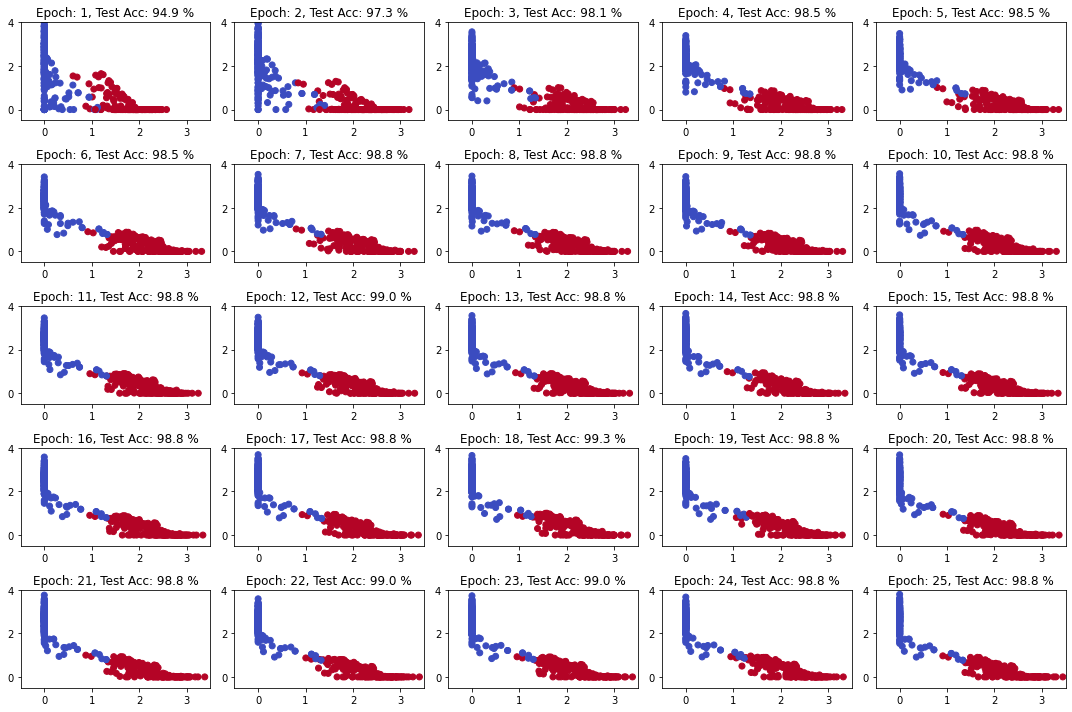

In [96]:
plt.figure(figsize=(15,10))

for i in range(1,26):
    plt.subplot(5,5,i)
    h = model.fit(X_train, y_train, batch_size=16, epochs=1, verbose=0)
    test_accuracy = model.evaluate(X_test, y_test)[1]
    features = features_function([X_test])[0]
    plt.scatter(features[:,0],features[:,1],c=y_test,cmap='coolwarm')
    plt.xlim(-0.5,3.5)
    plt.ylim(-0.5,4.0)
    plt.title('Epoch: {}, Test Acc: {:3.1f} %'.format(i, test_accuracy*100.0))
    
plt.tight_layout()